# Mad1 inference new objective function 

Import the relevant packages and simulations.

In [1]:
using Random, Plots, LaTeXStrings, Distributions, StatsBase, DataFrames, CSV, Plots.PlotMeasures, Revise, GpABC, JLD

In [2]:
Plots.theme(:dao)
Plots.gr_cbar_width[] = 0.01;

In [3]:
Revise.track("/home/jamesh/GitHub/volume-inference-take-2/SSA-basic.jl")
include("/home/jamesh/GitHub/volume-inference-take-2/SSA-basic.jl")
using .SSAnonVD

Define a nice colorblind color scheme.

In [4]:
pal = cgrad(:tol_muted);
cpal = [pal[i] for i in 1/7:1/7:1.0]
population_colors = cpal

Import the data.

In [5]:
df_nuc = DataFrame(CSV.File("/home/jamesh/GitHub/volume-inference-take-2/data/nuclear-vol-corr.csv"));
df_cyto = DataFrame(CSV.File("/home/jamesh/GitHub/volume-inference-take-2/data/cyto-vol-corr.csv"));
delete!(df_nuc, 2);
delete!(df_cyto, 2);

In [6]:
gnames = df_cyto[!,"gene"]
Ns = df_nuc[!,"N"];
cyto_means = df_cyto[!,"Mean"];
nuc_FFs = df_nuc[!,"FF"];
cyto_FFs = df_cyto[!,"FF"];

Mad1-endog is the third gene in `gnames`.

In [7]:
mad1N = Ns[3]; mad1cyto = cyto_means[3]; mad1FFn = nuc_FFs[3]; mad1FFc = cyto_FFs[3];

Define the timescales necessary to predict the steady-state time. `sim_time` defines the point at which the steady state is assumed to be reached.

In [8]:
tdeg = 1;
texpt(kA,kB,kC,S,R) = 1/kC;
tinit(kA,kB,kC,S,R) = (1/kB)+(S-1)/kA;

In [9]:
function sim_time(pars)
    kA, kB, kC = pars;
    return 10*maximum([1,texpt(pars...,hypars...),tinit(pars...,hypars...)])
end

sim_time (generic function with 1 method)

Import the values from the bootstrapping for the distance function weighting. It is the inverse of these errors that multiples each square error (larger variance in the sample statistic gives it a lesser weighting in the objective function). 

In [10]:
bootstrapping = DataFrame(CSV.File("/home/jamesh/GitHub/volume-inference-take-2/data/meanCyto_FF_withVar_forJames_230422.csv"))

10×12 DataFrame
 Row │ gene                     meanRNA_Cytoplasm  FF_Nucleus  FF_Cytoplasm  v ⋯
     │ String31                 Float64            Float64     Float64       F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ mad1endog                          1.74188    0.927854      0.61919     ⋯
   2 │ mad1WTymEGFP                       2.85198    0.981871      0.65653
   3 │ mad2WTymEGFP                       2.89682    0.843934      0.823882
   4 │ mad3WTymEGFP                       3.51958    0.973071      0.70773
   5 │ bub1WTymEGFP                       4.40106    0.951047      0.619662    ⋯
   6 │ sep1WTymEGFP-hph                   5.42775    0.863251      0.87657
   7 │ rpb1endog                         17.8805     0.824811      0.646176
   8 │ cdc13endog                        18.5235     0.92621       0.994492
   9 │ SPAC2H1001WTymEGFP-hph             3.24427    2.19847       4.08452     ⋯
  10 │ SPAC27D709cWTymEGFP-hph           25.2452     2.83368       9.69815
                                                               8 columns omitted

In [11]:
names(bootstrapping);

Take the bootstrapped sample variances.

In [12]:
bs_cyto = bootstrapping[!,"varmeanRNA_Cytoplasm"][1]
bs_ffn = bootstrapping[!,"varFF_Nucleus"][1]
bs_ffc = bootstrapping[!,"varFF_Cytoplasm"][1];
bs_vec = [bs_cyto, bs_ffn, bs_ffc];

Define the distance function.

In [13]:
function new_distance(traj1::Matrix, traj2::Matrix)
    return sum([bs_vec[i]^(-1)*((traj1[i]-traj2[i])/traj2[i])^2 for i in 1:length(traj1)])
end
function new_distance(traj1::Vector, traj2::Vector)
    return sum([bs_vec[i]^(-1)*((traj1[i]-traj2[i])/traj2[i])^2 for i in 1:length(traj1)])
end

new_distance (generic function with 2 methods)

# Let's do for $R=S=3$

Set the hyperparameters to $S=R=3$.

In [14]:
hypars = [3,3]; # [S,R]
# pf defined for the priors (see SI).
pf = (hypars[1]-1)/2

1.0

In [15]:
gnames[3]

"mad1endog"

In [16]:
function simulator_fn_3(pars)
    op = SSA(Ns[3], pars, hypars, sim_time(pars), sim_time(pars));
    nuc_pop = op[1][:,2];
    cyto_pop = op[2][:,2];
    nuc_FF = var(nuc_pop)/mean(nuc_pop);
    cyto_mean = 2*mean(cyto_pop);
    cyto_FF = var(cyto_pop)/mean(cyto_pop);
    # return the moments of interest
    return reshape([cyto_mean, nuc_FF, cyto_FF],(3,1))
end

simulator_fn_3 (generic function with 1 method)

Let's look at the value of the objective function for something close to an optimum value. This informs what our threshold schedule for the ABC will be.

In [17]:
new_distance(simulator_fn_3([2.54,3.64,20.0]),reshape([cyto_means[3],nuc_FFs[3],cyto_FFs[3]],(3,1)))

35.17130476853963

In [18]:
# ABC priors
priors_3 = [Uniform(pf*0.5,pf*10.5), Uniform(0.5, 10.5), Uniform(0.5,100.5)]

# number of particles
n_particles = 1000

# ABC hpars
threshold_schedule_3 = [200.0, 100.0, 50.0, 25.0, 20.0, 10.0, 5.0]

7-element Vector{Float64}:
 200.0
 100.0
  50.0
  25.0
  20.0
  10.0
   5.0

In [19]:
sim_abcsmc_res_3 = SimulatedABCSMC(reshape([cyto_means[3],nuc_FFs[3],cyto_FFs[3]],(3,1)),
    simulator_fn_3,
    priors_3,
    threshold_schedule_3,
    n_particles; 
    max_iter=convert(Int, 1e5),
    distance_function = new_distance,
    write_progress=true);

[ Info: GpABC rejection simulation. ϵ = 200.0.
[ Info: GpABC rejection simulation. Accepted 246/1000 particles.
[ Info: GpABC rejection simulation. Accepted 492/2000 particles.
[ Info: GpABC rejection simulation. Accepted 754/3000 particles.
[ Info: GpABC rejection simulation. Accepted 991/4000 particles.
[ Info: GpABC SMC simulation ϵ = 100.0
[ Info: GpABC SMC simulation accepted 256/1000 particles.
[ Info: GpABC SMC simulation accepted 505/2000 particles.
[ Info: GpABC SMC simulation accepted 729/3000 particles.
[ Info: GpABC SMC simulation accepted 984/4000 particles.
[ Info: GpABC SMC simulation ϵ = 50.0
[ Info: GpABC SMC simulation accepted 280/1000 particles.
[ Info: GpABC SMC simulation accepted 541/2000 particles.
[ Info: GpABC SMC simulation accepted 802/3000 particles.
[ Info: GpABC SMC simulation ϵ = 25.0
[ Info: GpABC SMC simulation accepted 242/1000 particles.
[ Info: GpABC SMC simulation accepted 466/2000 particles.
[ Info: GpABC SMC simulation accepted 691/3000 particles

Quick look at the results...

In [20]:
plot(sim_abcsmc_res_3, population_colors=population_colors)

Save these results using the JLD package.

In [43]:
save("./ABC-new/ABC-redo/mad1endog/S3R3.jld", "ABC", sim_abcsmc_res_3)

Let's collect the important aspects of this ABC for analysis. We want:
- 1. The parameter values of the accepted particles.
- 2. The acceptance rate for the final threshold.

Note the different field names are: `n_accepted`, `n_tries`, `threshold_schedule`, `population`, `distances`, `weights`.

In [22]:
acc_rate = sim_abcsmc_res_3.n_accepted[end]/sim_abcsmc_res_3.n_tries[end]

0.03642987249544627

So the acceptance rate at the final threshold was around 0.2. Let's now look at the mean and standard deviations of the predicted values of $k_A$, $k_B$ and $k_C$ from the population.

In [23]:
pop = sim_abcsmc_res_3.population[end];

In [24]:
kA = pop[:,1]; kB = pop[:,2]; kC = pop[:,3];

In [25]:
kAmed = median(kA)

2.5585564762219017

In [26]:
kAstd = std(kA)

0.34869771289264984

In [27]:
kBmed = median(kB)

2.461903974682346

In [28]:
kBstd = std(kB)

0.7199133215896935

In [29]:
kCmed = median(kC)

34.048913253280396

In [30]:
kCstd = std(kC)

20.551754624108632

Let's make some nice plots of these (the three histograms followed by the joint uncertainty plots as a 2D hist).

In [51]:
h1 = stephist(kA, fill = true, fillalpha = 0.5, color = cpal[1], label = :none, norm = true, titlelocation = :left)
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), xlabel = L"k_A", title = "(a)", ylims = [0,1.3])
plot!([kAmed,kAmed],[0,100], style = :dash, color = :black, label = L"$k_C$ median");

In [52]:
h2 = stephist(kB, fill = true, fillalpha = 0.5, color = cpal[2], label = :none, norm = true, titlelocation = :left)
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), xlabel = L"k_B", title = "(b)", ylims = [0,0.8])
plot!([kBmed,kBmed],[0,1.2], style = :dash, color = :black, label = L"$k_B$ median");

In [53]:
h3 = stephist(kC, fill = true, fillalpha = 0.5, color = cpal[3], label = :none, norm = true, titlelocation = :left)
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), xlabel = L"k_C", 
        title = "(c)", ylims = [0,0.023])
plot!([kCmed,kCmed],[0,2], style = :dash, color = :black, label = L"$k_C$ median");

In [55]:
c1 = plot(h1, h2, h3, layout = (1,3), size = (1000, 300), bottom_margin = 5mm, top_margin = 5mm);

In [64]:
p1 = histogram2d(kA, kB, color=:tol_muted, show_empty_bins=true, titlelocation = :left, 
    bins = (collect(minimum(kA):(maximum(kA)-minimum(kA))/20:maximum(kA)), collect(minimum(kB):(maximum(kB)-minimum(kB))/20:maximum(kB))))
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), 
    xlabel = L"k_A", ylabel = L"k_B", title = "(d)");

In [66]:
p2 = histogram2d(kA, kC, color=:tol_muted, show_empty_bins=true, titlelocation = :left, 
    bins = (collect(minimum(kA):(maximum(kA)-minimum(kA))/20:maximum(kA)), collect(minimum(kC):(maximum(kC)-minimum(kC))/20:maximum(kC))))
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), 
    xlabel = L"k_A", ylabel = L"k_C", title = "(e)");

In [65]:
p3 = histogram2d(kB, kC, color=:tol_muted, show_empty_bins=true, titlelocation = :left, 
    bins = (collect(minimum(kB):(maximum(kB)-minimum(kB))/20:maximum(kB)), collect(minimum(kC):(maximum(kC)-minimum(kC))/20:maximum(kC))))
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), 
    xlabel = L"k_B", ylabel = L"k_C", title = "(f)");

In [67]:
c2 = plot(p1, p2, p3, layout = (1,3), size = (1000, 300), bottom_margin = 5mm, top_margin = 5mm, left_margin = 5.0mm, right_margin = -10mm);

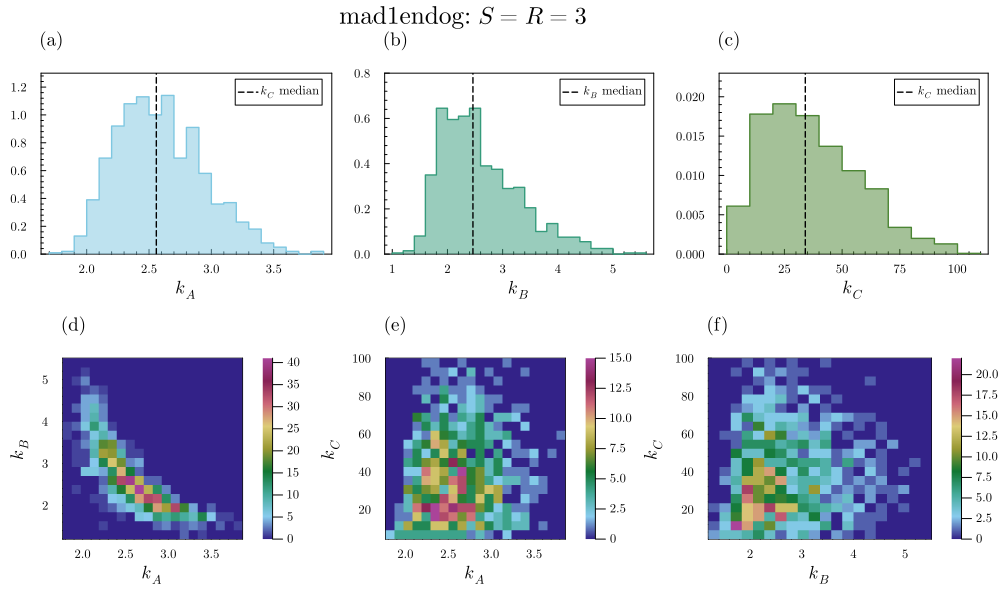

In [70]:
plot(c1,c2, layout = (2,1), size = (1000,600), plot_title=L"%$(gnames[3]): $S=R=3$")
# savefig("./ABC-new/figs/mad1endog/S3R3.pdf")

Check if the moments replicate those from the original data.

In [40]:
[cyto_means[3],nuc_FFs[3],cyto_FFs[3]]

3-element Vector{Float64}:
 1.74181548708104
 0.92893586062368
 0.619817985303977

In [41]:
mean([simulator_fn_3([kAmed,kBmed,kCmed]) for i in 1:100])

3×1 Matrix{Float64}:
 1.7286685962373367
 0.9766401158580739
 0.6369898794903621

So, pretty good overall.